## Problem 3: Learning a data-driven Linear Dynamical System (LDS)

### Part A:
Find the data associated with the jPCA paper (included as `exampleData.mat`). Load up
the data, and read the `NOTES.pdf` file to identify which data matrix corresponds to “condition
27”. What do the values in this matrix represent? Plot the data as a heatmap.


The \textttt{Notes.pdf} says that "each of the 108 elements is one 'condition': one reach type that our monkey performed.' This means that these are neural recordings from  

In [2]:
from sthom215_problem_3_ex_3 import *
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

pwd = Path().cwd()
fname = 'exampleData.mat'
fpath = pwd / fname
COND = 27

mat, time_steps = loadData(COND, fpath)


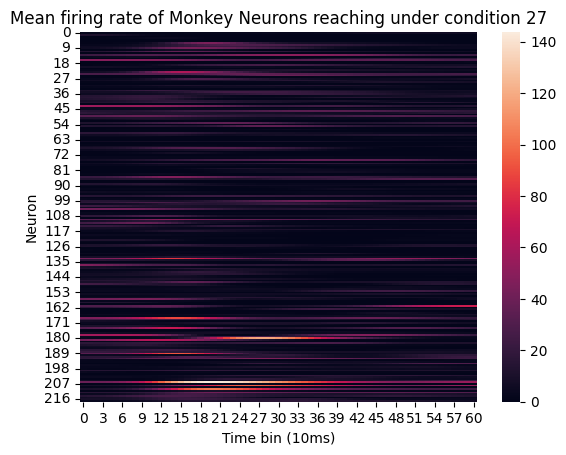

In [3]:
sns.heatmap(mat, fmt=".2f", cbar=True)

# Set the axis labels
plt.xlabel("Time bin (10ms)")
plt.ylabel("Neuron")

# Set the title of the plot
plt.title(f"Mean firing rate of Monkey Neurons reaching under condition {COND}")

# Show the plot
plt.show()

### Part B 
In this problem we will set up the optimization to learn a linear system guiding a
population of neurons. For one dataset write out the probabilistic model corresponding to the
discrete approximation of $\frac{dx_t}{dt} = Ax_t + \epsilon$ where $\epsilon$ is independently identically distributed
Gaussian noise with zero mean and standard deviation $\sigma^2I$. For the discretization, use the simple
approximation to the differential: $\frac{dx_t}{dt} \approx \frac{x_t - x_{t-1}}{dt}$. Now what is the same solution
when given $k$ datasets that all follow the same dynamics? (Hint: think about each dataset as
independent: what’s an important property of independent random variables with respect to their
probabilities?). The derived likelihood represents $P(x|A)$. Use this to set up a ML estimate of
$A$. Code up in MATLAB the solution you derived and run on the jPCA dataset. Reconstruct
the data by taking each $x_t$ and predicting $x_{t+1}$ by taking one step given the dynamical system
you found (via the discrete equation you derived above). Compute the reconstruction error of
the data (norm of the difference between the estimated $x_{t+1}$ and the real $x_{t+1}$), and plot the
histogram of these errors across all time-points.



In [1]:
# run system forward one step
import numpy as np 
import numpy.linalg as la

bin = 5
mat27, time_bins = loadData(COND, fpath)
# beginning changes in the system
A = np.cov(mat27)

NameError: name 'loadData' is not defined

$\dot{x} = Ax +\varepsilon$


Approx by $dt$

$dx = \frac{dt_1-\Delta}{t}$

$$||\frac{dx_i}{dt} - Ax_i ||_F$$

In [9]:
# A(trial) 
# A = [A[1,...,T,], A[0,...,T-1,]]

(218, 218)

In [20]:
bin = 10
x0 = mat[:,bin]
x1 = mat[:,bin+1]

In [21]:
x1_hat = A @ x0

In [22]:
err1 = la.norm(x1_hat - x1, ord=2)
# err2 = la.norm(recon_28 - mat28, ord='fro')

print(f"Reconstruction error is {err1} for condition {COND}")
# print(f"Reconstruction error is {err2} for condition {COND+1}")

Reconstruction error is 1192323.3790855033 for condition 27


## Part C
Repeat part B but consider only the top 6 principal components of each matrix $X$.
REMEMBER: PCA projection includes a mean subtraction step! This is very important in projecting the data! Compute again the reconstruction error of the data given the learned dynamical system (with a one-step prediction), and plot the histogram of errors.


## Part D
The learned dynamics should provide a projection of the data onto a given space. Take
one of the first 6 datapoints in each dataset in the jPCA datasets, and use the learned dynamics
from Part C to extrapolate the neural system forward in time. Plot the first two dynamical
principal dimensions of the projection: how do they look?


## Part E
Now run the jPCA algorithm on the same data. Look at the code and notes provided
by the authors and find the right lines of code to run on the dataset. Find the learned dynamics
and project the data forward as with Part D. Use “subplot” to plot the projected neural activity
next to each other. What key differences do you see between the dynamics? What differences
between the dynamical system matrices do you see? Are there similarities or differences e.g., in
the eigenspectra?

